In [2]:
from getpass import getpass

rdm_url = 'http://localhost:5001/'
# テスト対象のプロジェクト情報 (1) - idp_usernameのユーザーがアクセスできる必要あり
rdm_project_url_1 = 'http://localhost:5001/tvuxd/'
rdm_project_name_1 = 'test_login'
# テスト対象のプロジェクト情報 (2) - idp_usernameのユーザーがアクセスできてはならない
rdm_project_url_2 = 'http://localhost:5001/xwz59/'
idp_name = 'FakeCAS'
idp_username = 'satoshiyazawa9+user@example.com'
idp_password = 'fakecas_not_needs_password'
default_result_path = None
close_on_fail = False
transition_timeout = 60000

In [3]:
if idp_username is None:
    idp_username = input(prompt=f'Username for {idp_name}')
if idp_password is None:
    idp_password = getpass(prompt=f'Password for {idp_username}@{idp_name}')
(len(idp_username), len(idp_password))

(29, 26)

In [4]:
import tempfile

work_dir = tempfile.mkdtemp()
if default_result_path is None:
    default_result_path = work_dir
work_dir

'/var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmpzgsgtw60'

In [5]:
assert rdm_project_url_1.startswith(rdm_url), 'パラメータ `rdm_project_url_1` は、 `rdm_url` と同一ドメインでなければなりません。'
assert rdm_project_url_2.startswith(rdm_url), 'パラメータ `rdm_project_url_2` は、 `rdm_url` と同一ドメインでなければなりません。'

# GakuNinRDM 総合テスト [ログイン]

- サブシステム名: ログイン
- ページ/アドオン: トップページ
- 機能分類: アクセス制御確認
- シナリオ名: ログイン時挙動確認
- 用意するテストデータ: URL一覧、アカウント(既存ユーザー1: GRDM, test_loginプロジェクトに参加)

## ウェブブラウザの新規プライベートウィンドウでGRDMトップページを表示する

GRDMトップページが表示されること

In [7]:
import importlib
import pandas as pd

import scripts.playwright
importlib.reload(scripts.playwright)

from scripts.playwright import *
from scripts import grdm

await init_pw_context(close_on_fail=close_on_fail, last_path=default_result_path)

('20250806-074313',
 '/var/folders/m0/myy2ys0s3cl_73__2gw8fw140000gn/T/tmpx4xcejay')

Start epoch: 1754433798.035991 seconds


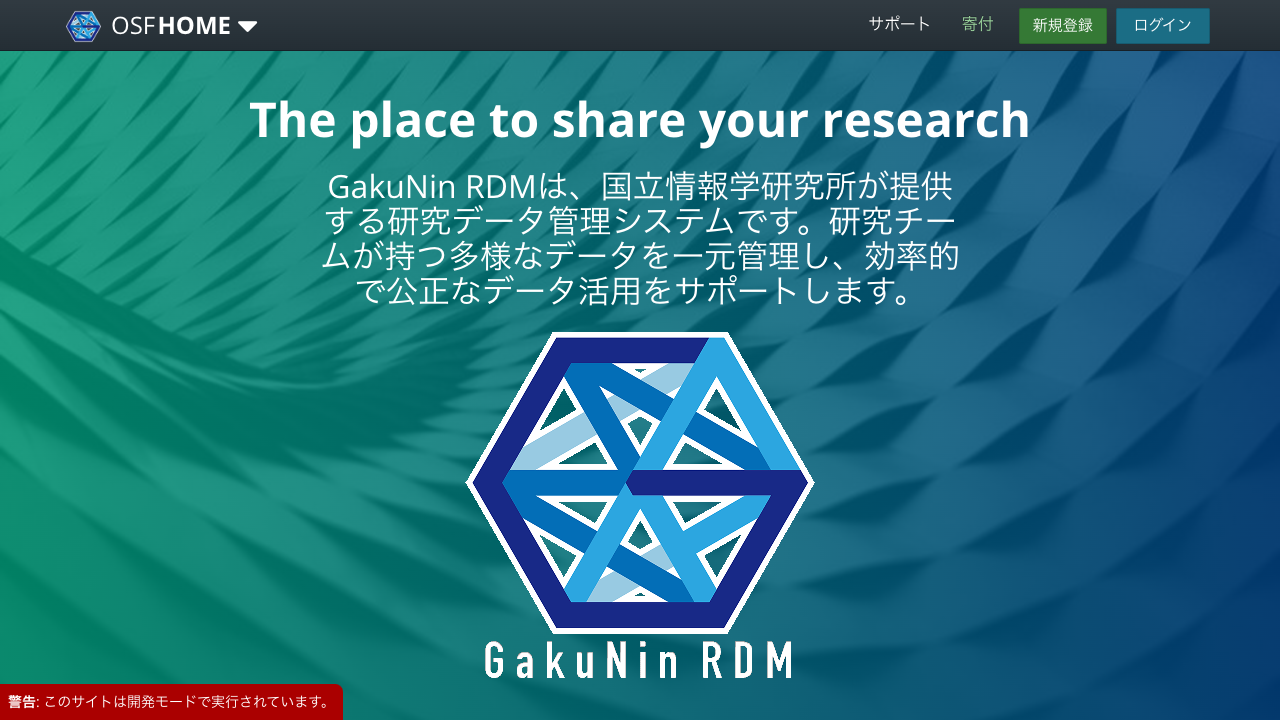

In [8]:
import time

async def _step(page):
    await page.goto(rdm_url)

    # 同意する ボタンが現れるまで待つ
    await expect(page.locator('//button[text() = "同意する"]')).to_be_visible(timeout=transition_timeout)

    # 同意する をクリック
    await page.locator('//button[text() = "同意する"]').click()

    # 同意する が表示されなくなったことを確認
    await expect(page.locator('//button[text() = "同意する"]')).to_have_count(0, timeout=500)

await run_pw(_step)

## (非FakeCAS) GakuNin Embeded DSのプルダウンを展開する

IdPの一覧が表示され選択可能なこと

Start epoch: 1743215519.9461734 seconds


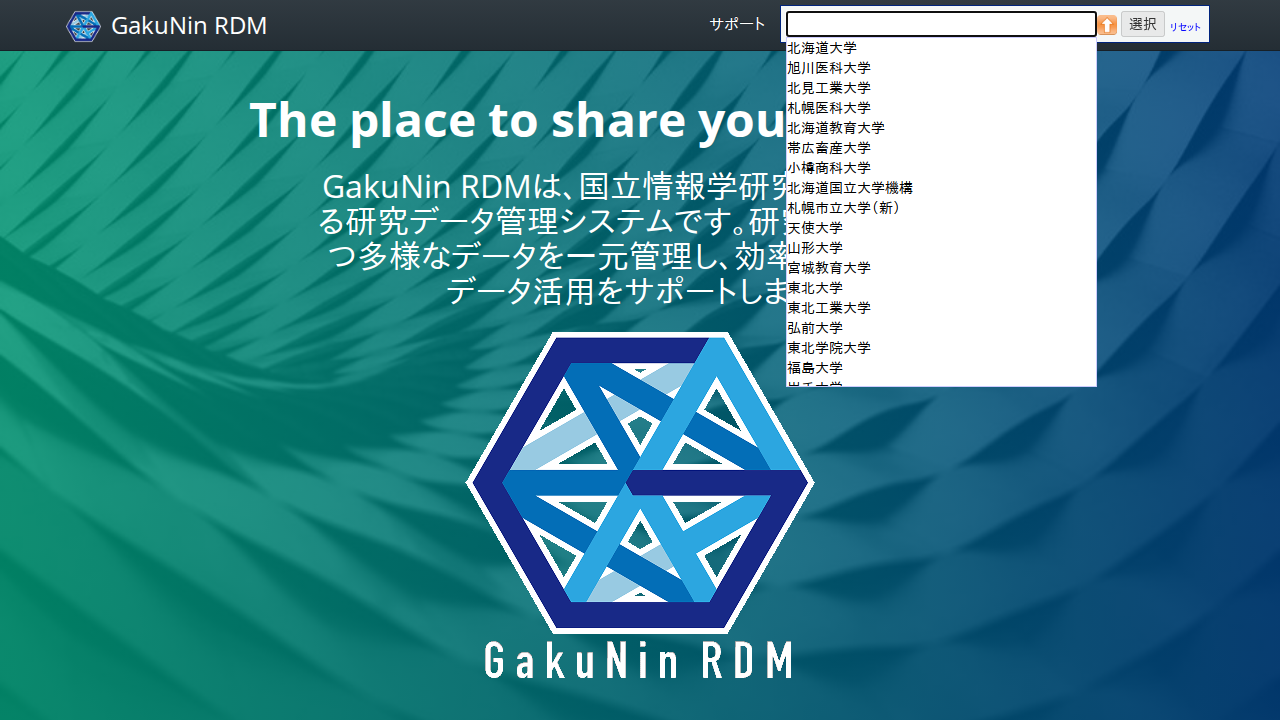

In [ ]:
async def _step(page):
    if idp_name == 'FakeCAS':
        return
    await page.locator('//*[@id = "dropdown_img"]').click()

    # IdPが要素として作成されることを確認
    locator = page.locator(f'//*[@class = "list_idp" and text() = "{idp_name}"]')
    await expect(locator).to_be_visible(timeout=transition_timeout)
    time.sleep(5)

await run_pw(_step)

## (非FakeCAS) IdPリストから「GakuNinRDM IdP」を選択する

Embeded DSが「GakuNinRDM IdP」を選択状態で表示されること

In [ ]:
async def _step(page):
    if idp_name == 'FakeCAS':
        # FakeCASの場合はIdP選択をスキップ
        return
        
    await page.locator(f'//*[@class = "list_idp" and text() = "{idp_name}"]').click()

    # 選択ボタンが有効になったことを確認
    await expect(page.locator('//input[@id = "wayf_submit_button"]')).to_be_enabled(timeout=transition_timeout)

await run_pw(_step)

## (非FakeCAS) Embeded DSの「選択」ボタンを押下する

GakuNin RDM IdPのログインフォームが表示されること

In [ ]:
async def _step(page):
    if idp_name == 'FakeCAS':
        # FakeCASの場合は既にログインフォームが表示されているはず
        return
        
    # 選択ボタンをクリック
    await page.locator('//input[@id = "wayf_submit_button"]').click()

    # アカウント入力欄が編集可能になったことを確認
    await expect(page.locator('#username')).to_be_editable(timeout=transition_timeout)

await run_pw(_step)

## アカウントのID/Passwordを入力して「Login」ボタンを押下する

GakuNin RDM IdPの承認画面が表示されること

Start epoch: 1743215542.5030417 seconds


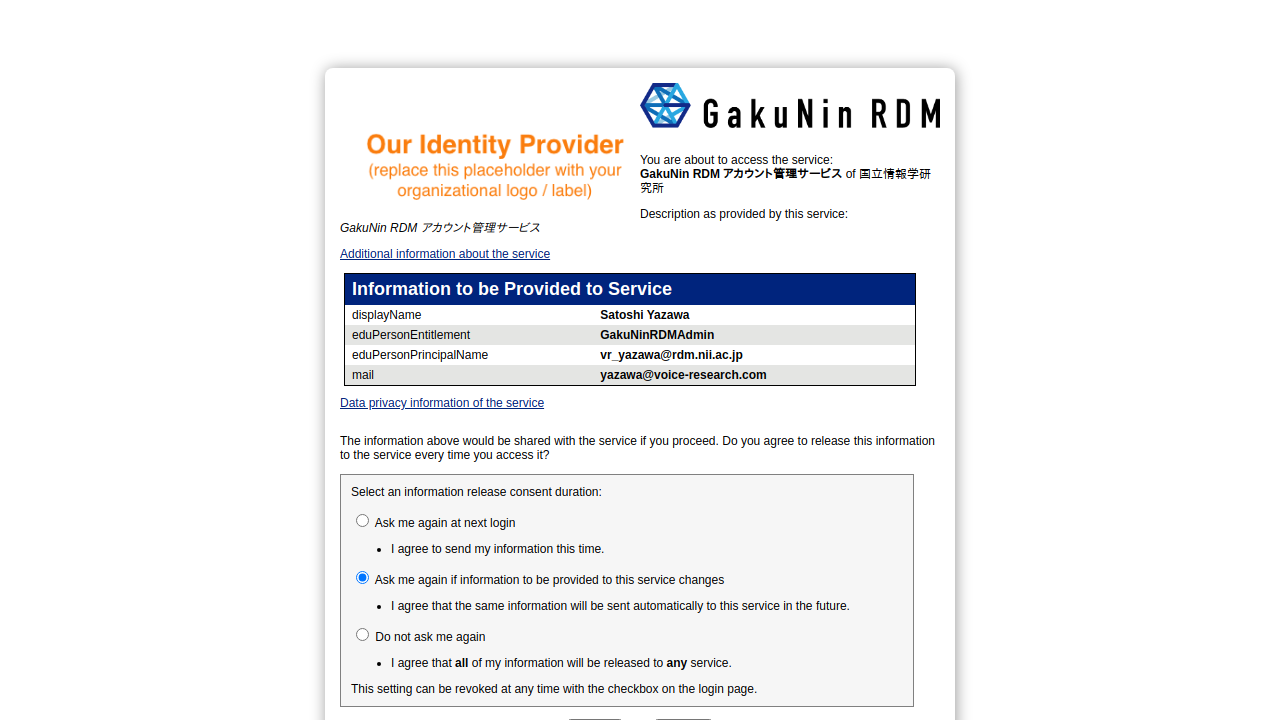

In [53]:
async def _step(page):
    # メールアドレスとパスワードを入力
    await page.locator('#username').fill(idp_username)
    await page.locator('#password').fill(idp_password)

    # サインインボタンが押下可能であることを確認
    await expect(page.locator('//button[@type = "submit"]')).to_be_enabled(timeout=transition_timeout)
    # サインインボタンをクリック
    await page.locator('//button[@type = "submit"]').click()

    # チェック「Ask me again at next login」が表示されることを確認
    await expect(page.locator('#_shib_idp_doNotRememberConsent')).to_be_enabled(timeout=transition_timeout)

await run_pw(_step)

## 「Ask me again at next login」をチェックし、「Accept」ボタンを押下する

GRDMダッシュボードが表示されること

Start epoch: 1743215543.0612466 seconds


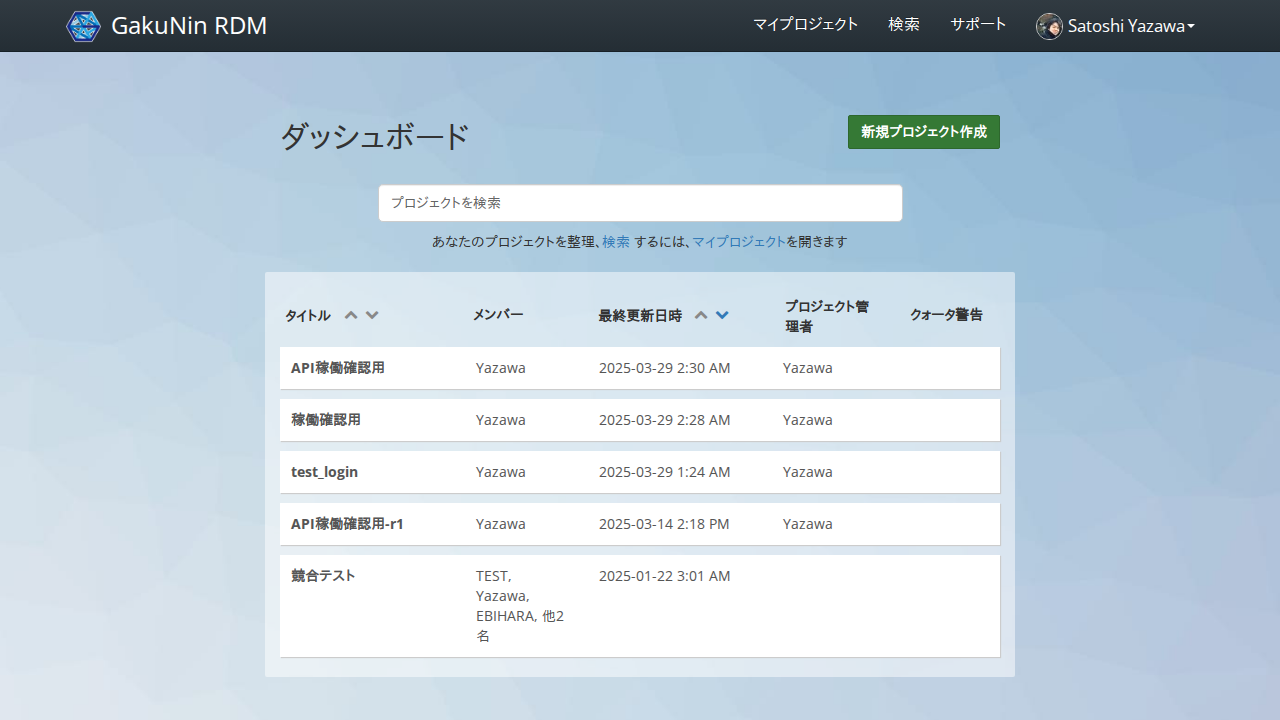

In [54]:
async def _step(page):
    await page.locator('#_shib_idp_doNotRememberConsent').click()
    await expect(page.locator('#_shib_idp_doNotRememberConsent')).to_be_checked()

    await expect(page.locator('//*[@name="_eventId_proceed"]')).to_be_enabled()
    await page.locator('//*[@name="_eventId_proceed"]').click()

    # GRDMのボタンが表示されることを確認
    await expect(page.locator('//*[text() = "プロジェクト管理者"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## ダッシュボードのプロジェクト一覧から「test_login」ブロジェクトのタイトルをクリックする

プロジェクトダッシュボードが表示されること

Start epoch: 1743215546.2476096 seconds


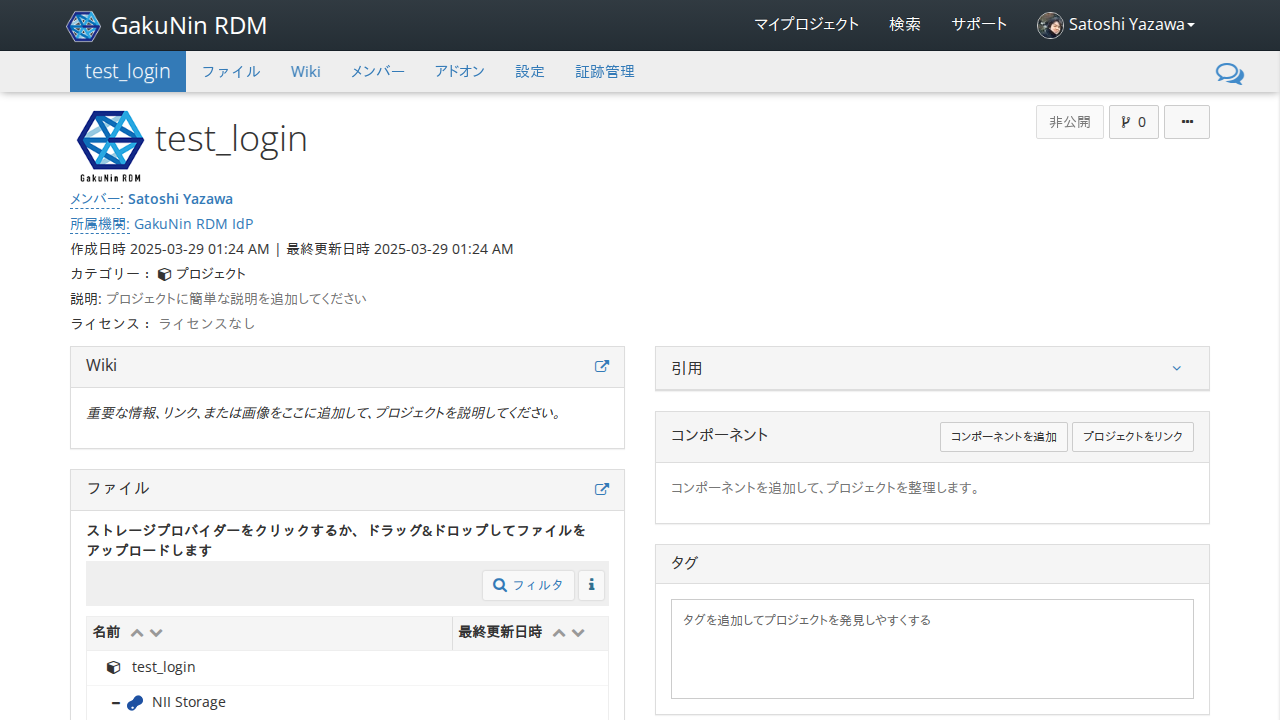

In [55]:
import traceback

async def _step(page):
    while True:
        try:
            await page.locator(f'//*[@data-test-dashboard-item-title and text() = "{rdm_project_name_1}"]').click()
            break
        except:
            print('Ignore... Load more')
            traceback.print_exc()
            await page.locator(f'//*[@data-test-load-more]').click()
    await expect(page.locator('//span[@id = "nodeTitleEditable"]')).to_be_visible(timeout=transition_timeout)

    await expect(page.locator('//a[text() = "アドオン"]')).to_be_visible(timeout=transition_timeout)
    await expect(grdm.get_select_expanded_storage_title_locator(page, 'NII Storage')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 既存プロジェクト1のURLをアドレスバーに入力する

プロジェクトダッシュボードが表示されること

Start epoch: 1743215548.3676875 seconds


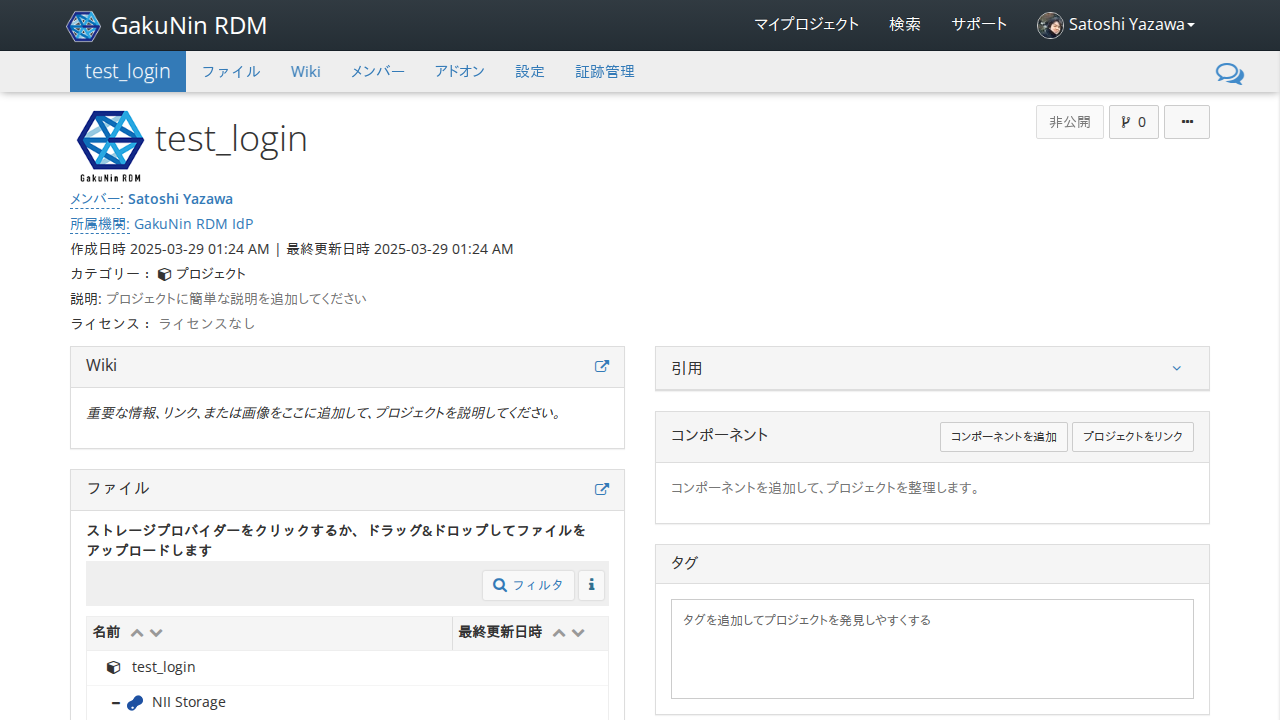

In [56]:
async def _step(page):
    await page.goto(rdm_project_url_1)
    await expect(page.locator('//span[@id = "nodeTitleEditable"]')).to_be_visible(timeout=transition_timeout)

    await expect(page.locator('//a[text() = "アドオン"]')).to_be_visible(timeout=transition_timeout)
    await expect(grdm.get_select_expanded_storage_title_locator(page, 'NII Storage')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 既存プロジェクト2のURLをアドレスバーに入力する

「許可が必要です」画面が表示されること

Start epoch: 1743215550.3260674 seconds


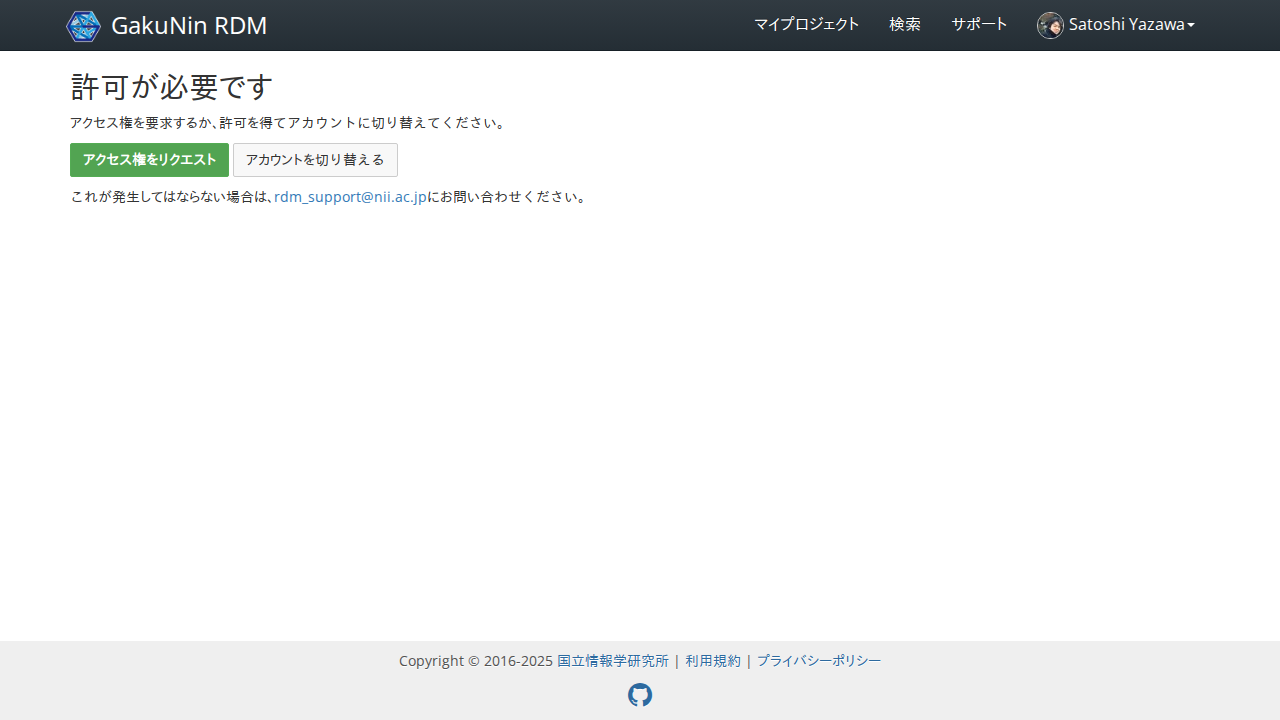

In [57]:
async def _step(page):
    await page.goto(rdm_project_url_2)

    await expect(page.locator('//button[text() = "アクセス権をリクエスト"]')).to_be_enabled(timeout=transition_timeout)

await run_pw(_step)

## ユーザーメニューから「ログアウト」を選択する

GRDMトップページが表示されること

In [ ]:
async def _step(page):
    await page.locator(f'//div[@class = "nav-profile-name"]').click()
    await page.locator('//*[contains(text(), "ログアウト")]').click()

    # ログアウト成功の確認
    if idp_name == 'FakeCAS':
        # FakeCASの場合はサインインボタンが表示されることを確認
        await expect(page.locator('//button[@data-test-sign-in-button]')).to_be_visible(timeout=transition_timeout)
    else:
        # 通常のGakuNin DSの場合はdropdown_imgが表示されることを確認
        await expect(page.locator('//*[@id = "dropdown_img"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 既存プロジェクト1のURLをアドレスバーに入力する

GakuNin DSの機関選択画面が表示されること

Start epoch: 1743215552.4391348 seconds


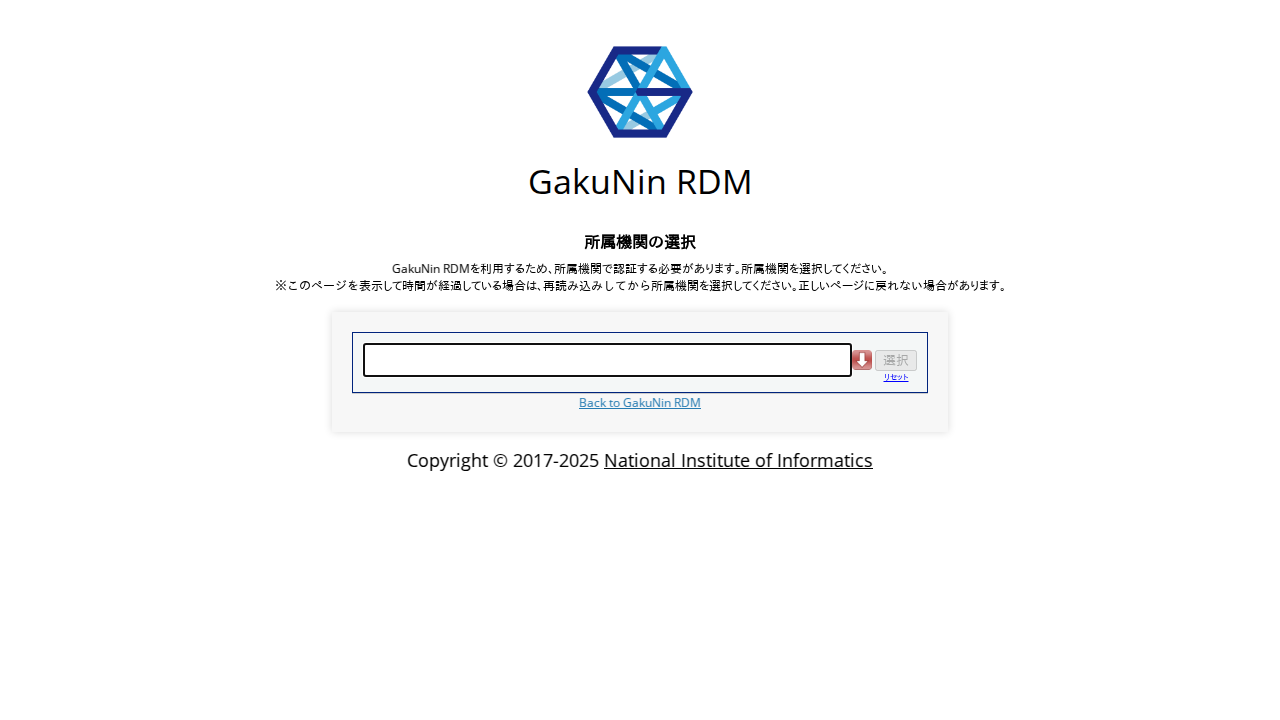

In [59]:
async def _step(page):
    await page.goto(rdm_project_url_1)
    await expect(page.locator('//*[text() = "所属機関の選択"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

終了処理を実施。

In [60]:
await finish_pw_context()

Video: /home/jovyan/last-screenshots/20250329-023151/video-1.webm
HAR: /home/jovyan/last-screenshots/20250329-023151/har.zip


In [61]:
!rm -fr {work_dir}